In [1]:
'''
Random Number Generation

Random Number generation is central to Monte Carlo simulation

'''

'\nRandom Number Generation\n\nRandom Number generation is central to Monte Carlo simulation\n\n'

In [50]:
import numpy as np
import datetime as dt

def sn_random_numbers(shape, antithetic=True, moment_matching=True, fixed_seed=False):
    '''
    Returns an ndarray of shape shape with pseudorandom numbers that are standard normal distribution
    
    Params:
    ##########
    shape: tuple (o, n, m): Generation of array of shape (o,n,m)
    antithetic: boolean: Antithetic variates or not
    VOCAB TIME: Antithetic in Monte Carlo context just means that for every generated path also takes it's opposite.
    Formally, multiple the path by the scalar -1 in all dimenstions: for (1…………n) also generate -1(1…………n)
    
    moment_matching: boolean: matching of first and second moments (mean, variance)
    fixed_seed: boolean : fix the seed or not
    
    Returns:
    ##########
    ran: (o,n,m) array of pseudorandom standard normally distributed numbers
    
    '''
    if fixed_seed:
        np.random.seed(1000)
    if antithetic:
        # divide by 2 because we're taking the antithetic as well
        ran = np.random.standard_normal((
        shape[0], shape[1], shape[2] // 2))
        ran = np.concatenate((ran, -ran), axis=2)
    else:
        ran = np.random.standard_normal((shape[0], shape[1], shape[2]))
    if moment_matching:
        # centralize the mean and std_deviation around the drawn population
        ran = ran - np.mean(ran)
        ran = ran / np.std(ran)
        print("Matching moments!")
    if shape[0] == 1:
        return ran[0]
    else:
        return ran
    

In [51]:
# without moment matching
snrn = sn_random_numbers((2,2,2), antithetic=False, moment_matching=False, fixed_seed=True)
snrn

array([[[-0.8044583 ,  0.32093155],
        [-0.02548288,  0.64432383]],

       [[-0.30079667,  0.38947455],
        [-0.1074373 , -0.47998308]]])

In [52]:
round(snrn.mean(), 6)

-0.045429

In [53]:
round(snrn.std(), 6)

0.451876

In [54]:
# with moment matching
snrn = sn_random_numbers((2,2,2), antithetic=False, moment_matching=True, fixed_seed=True)
snrn

Matching moments!


array([[[-1.67972865,  0.81075283],
        [ 0.04413963,  1.52641815]],

       [[-0.56512826,  0.96243813],
        [-0.13722505, -0.96166678]]])

In [55]:
round(snrn.mean(), 6)

-0.0

In [56]:
round(snrn.std(), 6)

1.0

In [69]:
class market_environment(object):
    '''
    class to model a market environment relevant for valuation
    
    Attributes
    ===========
    name: string - name of the market environment
    pricing_date: datetime - date of the market environment
    
    Methods
    =========
    add_constant: adds a constant market parameter
    get_constant: get constant
    add_lists: adds a list (of underlyings)
    get_list: gets a list
    add_curve: adds a market curve (i.e. yield curve)
    get_curve: gets a market curve
    add_environment: upserts whole market environments with constants, lists, curves
    
    '''
    def __init__(self, name, pricing_date):
        self.name = name
        self.pricing_date = pricing_date
        self.constants = {}
        self.lists = {}
        self.curves = {}
        
    def add_constant(self, key, constant):
        self.constants[key] = constant
    
    def get_constant(self, key):
        return self.constants[key]
    
    def add_list(self, key, list_object):
        self.lists[key] = list_object
        
    def get_list(self, key):
        return self.lists[key]
    
    def add_curve(self, key, curve):
        self.curves[key] = curve
        
    def get_curve(self, key):
        return self.curves[key]
    
    def add_environment(self, env):
        # overwrite values for class if they exist
        self.constants.update(env.constants)
        self.lists.update(env.lists)
        self.curves.update(env.curves)
        

In [70]:
'''
This is useful for calculating the general discount factor, in this case
exp(-r * t) at time t
Modeling this as a class:
'''
class constant_short_rate(object):
    '''
    Class for constant short rate discounting.
    
    Attributes
    ===========
    name: string - name of the object
    short_rate: float (positive) - constant rate for discounting
    
    Results
    ==========
    get_discount_factors: get discount factors given a list/array of timestamp objects
    '''
    
    def __init__(self, name, short_rate):
        self.name = name
        self.short_rate = short_rate
        if(short_rate < 0):
            raise ValueError('Short rate negative.')
    
    def get_discount_factors(self, date_list, dtobjects=True):
        if dtobjects is True:
            dlist = get_year_deltas(date_list)
        else:
            dlist = np.array(date_list)
        dflist = np.exp(self.short_rate * np.sort(-dlist)) # take negative of time fractions
        return np.array((date_list, dflist)).T

In [71]:
'''
Now build from a generic simulation class towards specific applications

'''
import numpy as np
import pandas as pd
class simulation_class(object):
    '''
    Provide base methods for simulation classes
    
    Params
    =========
    name: str - name of the object
    mar_env: market_environment - a market environment
    corr: bool - is this object correlated with another modeled object?
    
    Methods
    =========
    generated_time_grid: returns discretized time intervals for simulation
    get_instrument_values: returns current values of security simulated (as ndarray)
    '''
    
    def __init__(self, name, mar_env, corr):
        self.name = name
        self.pricing_date = mar_env.pricing_date
        self.initial_value = mar_env.get_constant('initial_value')
        self.volatility = mar_env.get_constant('volatility')
        self.final_date = mar_env.get_constant('final_date')
        self.currency = mar_env.get_constant('currency')
        self.frequency = mar_env.get_constant('frequency')
        self.paths = mar_env.get_constant('paths')
        self.discount_curve = mar_env.get_curve('discount_curve')
        try:
            # If there is a time grid in mar_env take it
            self.time_grid = mar_env.get_list('time_grid')
        except:
            self.time_grid = None
        try:
            # if there are special dates, add those
            self.special_dates = mar_env.get_list('special_dates')
        except:
            self.special_dates = []
        self.instrument_values = None
        self.correlated = corr
        if corr is True:
            # only needed when risk factors are correlated
            self.cholesky_matrix = mar_env.get_list('cholesky_matrix')
            self.rn_set = mar_env.get_list('rn_set')[self.name]
            self.random_numbers = mar_env.get_list('random_numbers')
        
    def generate_time_grid(self):
        start = self.pricing_date
        end = self.final_date
        # use pandas date range func to generate time grid
        # freq is pandas frequency char
        time_grid = pd.date_range(start=start, end=end, freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # add begin, end, special
        if start not in time_grid:
            time_grid.insert(0, start)
            
        if end not in time_grid:
            time_grid.append(end)
        if len(self.special_dates) > 0:
            # add all
            time_grid.extend(special_dates)
            # de-dup
            time_grid = list(set(time_grid))
            # sort
            time_grid.sort()
        # cast back to np array
        self.time_grid = np.array(time_grid)
    
    def get_instrument_values(self, fixed_seed=True):
        if self.instrument_values is None:
            # only initiative simulation if no values
            self.generate_paths(fixed_seed=fixed_seed, day_count=365.)
        elif fixed_seed is False:
            # also resim if not a fixed seed (i.e. monte carlo)
            self.generate_paths(fixed_seed=fixed_seed, day_count=365.)
        # Otherwise all set so return what was simulated already
        return self.instrument_values

In [72]:
'''
Set up the Euler Discretizatin of the Geometric Brownian Motion PDE
'''
class geometric_brownian_motion(simulation_class):
    '''
    Class to generate simulated paths based on the Black-Scholes-Merton GBM model
    
    Attributes
    =========
    name: string - name of obj
    mar_env: market_environment instance
    corr: Boolean - is this correlated to other modeled objects?
    
    Methods
    =========
    update: updates parameters
    generate_paths: returns Monte Carlo paths given env
    '''
    def __init__(self, name, mar_env, corr=False):
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
        
    def update(self, initial_value=None, volatility=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
        
    def generate_paths(self, fixed_seed=False, day_count=365.):
        if self.time_grid is None:
            self.generate_time_grid()
        # Grid size
        M = len(self.time_grid)
        # Number of Paths for Monte
        I = self.paths
        # ndArray of the Monte Carlo shape (time steps by number of evolutions)
        paths = np.zeros((M, I))
        # initialize first step of each trial with initial value
        paths[0] = self.initial_value

        if not self.correlated:
            # if not correlated, go random
            rand = sn_random_numbers((1, M, I), fixed_seed=fixed_seed)
        else:
            # if correlated, use correlation random numbers object from market_env
            rand = self.random_numbers

        short_rate = self.discount_curve.short_rate
        # short rate for drift process
        
        for t in range(1, len(self.time_grid)):
            # select right idx from random number set
            if not self.correlated:
                ran = rand[t]
            else:
                ran = np.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
        
            # difference between two dates as a year fraction (infinitisemal for Euler discretization)
            dt = (self.time_grid[t]- self.time_grid[t-1]).days / day_count        

            paths[t] = paths[t-1] * np.exp((short_rate - 0.5 * self.volatility ** 2) * dt +
                                          self.volatility * np.sqrt(dt) * ran)
            # ran is Brownian motion evolution
            # dt is time slice (weighting for this slice's evolution)
        
        self.instrument_values = paths
            

In [74]:
# Now let's actually do something with it!
me_gbm = market_environment('me_gbm', dt.datetime(2020, 1, 1))

In [75]:
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2020, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

In [76]:
csr = constant_short_rate('csr', 0.06)

In [77]:
me_gbm.add_curve('discount_curve', csr)

In [78]:
gbm = geometric_brownian_motion('gbm', me_gbm)

In [79]:
gbm.generate_time_grid()

In [80]:
gbm.time_grid

array([datetime.datetime(2020, 1, 1, 0, 0),
       datetime.datetime(2020, 1, 31, 0, 0),
       datetime.datetime(2020, 2, 29, 0, 0),
       datetime.datetime(2020, 3, 31, 0, 0),
       datetime.datetime(2020, 4, 30, 0, 0),
       datetime.datetime(2020, 5, 31, 0, 0),
       datetime.datetime(2020, 6, 30, 0, 0),
       datetime.datetime(2020, 7, 31, 0, 0),
       datetime.datetime(2020, 8, 31, 0, 0),
       datetime.datetime(2020, 9, 30, 0, 0),
       datetime.datetime(2020, 10, 31, 0, 0),
       datetime.datetime(2020, 11, 30, 0, 0),
       datetime.datetime(2020, 12, 31, 0, 0)], dtype=object)

In [81]:
%time paths_1 = gbm.get_instrument_values()

Matching moments!
CPU times: user 14.5 ms, sys: 13.5 ms, total: 28 ms
Wall time: 38.6 ms


In [82]:
paths_1.round(3)

array([[36.   , 36.   , 36.   , ..., 36.   , 36.   , 36.   ],
       [37.403, 38.12 , 34.4  , ..., 36.252, 35.084, 39.668],
       [39.562, 42.335, 32.405, ..., 34.836, 33.637, 37.655],
       ...,
       [40.534, 33.506, 23.497, ..., 37.851, 30.122, 30.446],
       [42.527, 36.995, 21.885, ..., 36.014, 30.907, 30.712],
       [43.811, 37.876, 24.1  , ..., 36.263, 28.138, 29.038]])

In [83]:
gbm.update(volatility=0.5)

In [84]:
%time paths_2 = gbm.get_instrument_values()

Matching moments!
CPU times: user 7.07 ms, sys: 2.74 ms, total: 9.8 ms
Wall time: 5.94 ms


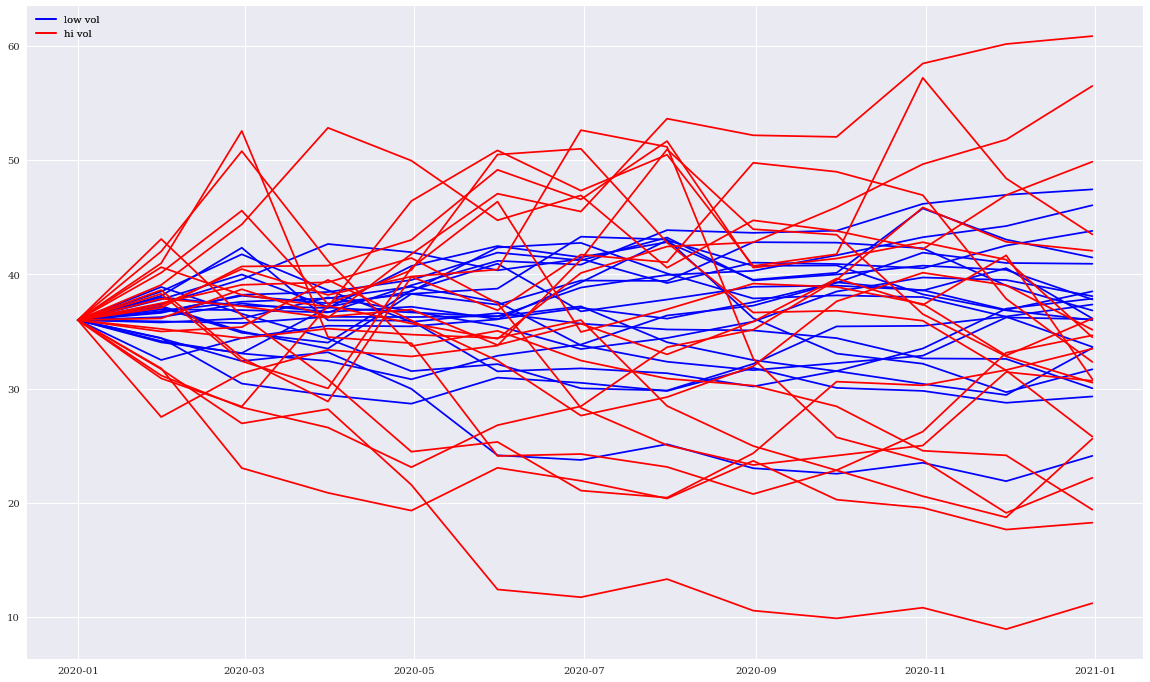

In [89]:
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
plt.figure(figsize=(20,12))
p1 = plt.plot(gbm.time_grid, paths_1[:, :20], 'b')
p2 = plt.plot(gbm.time_grid, paths_2[:, :20], 'r')
l1 = plt.legend([p1[0], p2[0]], ['low vol', 'hi vol'], loc=2)
plt.gca().add_artist(l1)
plt.xticks()